In [54]:
%matplotlib widget
import numpy as np_orig
import matplotlib.pyplot as plt
def plot_3d(x):
    X = [x[0], x[3], x[6]]
    Y = [x[1], x[4], x[7]]
    Z = [x[2], x[5], x[8]]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    labels = ['O', 'H1', 'H2']
    plt.title("Water Molecule")
    
    ax.text(x[0], x[1], x[2], 'O', color='red')
    ax.text(x[3], x[4], x[5], 'H1', color='red')
    ax.text(x[6], x[7], x[8], 'H2', color='red')
    
    ax.scatter3D(X,Y,Z)
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')

In [3]:
# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

def build_xyz(r, angle): # prepares an equilateral triagnle's coordinates of H3+!
    r = r/bohr_angs
    x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    
    # O at (0,0,0)
    x[0] = 0.0
    x[1] = 0.0
    x[2] = 0.0
    
    # H1 at (r*cos(angle),r*sin(angle),0)
    x[3] = r * np.cos(angle * np.pi/180)
    x[4] = r * np.sin(angle * np.pi/180)
    x[5] = 0.0
    
    # H2 at (r, 0, 0)
    x[6] = r
    x[7] = 0.0
    x[8] = 0.0
    
    # rotate water:
    new_x = rotate_water(x, axis, rot_angle)
    
    return new_x

# functions to keep track of convergence of O-H1, O-H2 bond angle during water's geometry optimization

import math

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2':

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * 180/math.pi) #convert to degrees

In [4]:
import math

def R_from_axis_angle(axis, angle):
    """ Find the rotation matrix R(K, theta) 
        @param axis (K): axis of rotation and 
        @param theta: rotation angle in degrees
        @return R: rotation matrix (3x3 numpy array)
    """
    sina = math.sin(angle * np.pi/180) # convert to radians
    cosa = math.cos(angle * np.pi/180) # convert to radians
    axis = unit_vector(axis[:3])
    kx = axis[0]; ky = axis[1]; kz = axis[2]
    # rotation matrix around unit vector
    
    R = np.array([
                [(kx**2)*(1-cosa) + cosa, kx*ky*(1-cosa)-kz*sina, kx*kz*(1-cosa)+ky*sina],
                [kx*ky*(1-cosa)+kz*sina, (ky**2)*(1-cosa) + cosa, ky*kz*(1-cosa)-kx*sina],
                [kx*kz*(1-cosa)-ky*sina, ky*kz*(1-cosa)+kx*sina, (kz**2)*(1-cosa) + cosa]
                ])
    
    return R

def rotate_water(x, axis, angle):
    rotation_matrix = R_from_axis_angle(axis, angle)
    new_x = np.array([0.0, 0.0, 0.0,0.0, 0.0, 0.0,0.0, 0.0, 0.0], requires_grad=True)
    
    # Rotate each vertex
    point1 = x[0:3]
    point1_rot = np.dot(rotation_matrix, point1) # Ordering matters. First rotate, then translate.
    point1_rot += transl_vec
    new_x[0:3] = point1_rot
    
    point2 = x[3:6]
    point2_rot = np.dot(rotation_matrix, point2)
    point2_rot += transl_vec
    new_x[3:6] = point2_rot
    
    point3 = x[6:9]
    point3_rot = np.dot(rotation_matrix, point3)
    point3_rot += transl_vec
    new_x[6:9] = point3_rot
    
    return new_x

In [9]:
################ Code from the 'Optimization of molecular geometries' tutorial##################
# imports and relevant defines:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import time

# Simulation starting parameters:
symbols = ["Be", "H", "H"]

# this is selected from the tutorial 'Building molecular Hamiltonians', which has the same nulcear-coordinats for water
x = np.array([ 0.8765    ,  1.9857    , -2.4895    ,  0.83258936,  0.27791693,
        -2.71614899,  0.9293593 ,  3.70744234, -2.5407848 ], requires_grad=True)

# these parameters are used to match up with the parameters for the VQE run on water in the paper: https://arxiv.org/pdf/2106.13840.pdf
active_electrons = 4
active_orbitals = 6

# define the hamiltonian needed to compute cost-function
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons, active_orbitals = active_orbitals)[0]

hf = qml.qchem.hf_state(electrons=active_electrons, orbitals=active_orbitals*2)
print(hf)
num_wires = 6

[1 1 1 1 0 0 0 0 0 0 0 0]


In [10]:
################ Code from the 'Building the adaptive circuit' tutorial below:################
active_electrons = active_electrons
active_orbitals = active_orbitals

H, qubits = qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons, active_orbitals = active_orbitals)
singles, doubles = qchem.excitations(active_electrons, qubits)

hf_state = qchem.hf_state(active_electrons, qubits)
print(hf_state)


#qubits = 14
#compute the significant double-excitation gates:
def circuit_1(params, excitations):
    qml.BasisState(hf_state, wires=range(qubits))
    #qml.StatePrep(wf_cisd, wires=range(qubits))

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(H)

dev = qml.device("default.qubit", wires=qubits)
cost_fn = qml.QNode(circuit_1, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(doubles)
grads = circuit_gradient(params, excitations=doubles)
print("Computed gradients for all possible Double Excitation Gates: \n")
for i in range(len(doubles)):
    print(f"Excitation : {doubles[i]}, Gradient: {grads[i]}")   
doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected double-excitation gates: ", len(doubles_select))



# optimizing the parameters for the double-excitation gates for Ansatz-wavefunction construction
opt = qml.GradientDescentOptimizer(stepsize=0.5)
params_doubles = np.zeros(len(doubles_select), requires_grad=True)
for n in range(20):
    params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)
print("Done!")



#compute the significant single-excitation gates:
def circuit_2(params, excitations, gates_select, params_select):
    qml.BasisState(hf_state, wires=range(qubits))
    #qml.StatePrep(wf_cisd, wires=range(qubits))

    for i, gate in enumerate(gates_select):
        if len(gate) == 4:
            qml.DoubleExcitation(params_select[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params_select[i], wires=gate)

    for i, gate in enumerate(excitations):
        if len(gate) == 4:
            qml.DoubleExcitation(params[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params[i], wires=gate)
    return qml.expval(H)


cost_fn = qml.QNode(circuit_2, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(singles)
grads = circuit_gradient(
    params,
    excitations=singles,
    gates_select=doubles_select,
    params_select=params_doubles
)
print("Computed gradients for all possible Single Excitation Gates: \n")
for i in range(len(singles)):
    print(f"Excitation : {singles[i]}, Gradient: {grads[i]}")
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected single-excitation gates: ", len(singles_select))

#Total Number of Gates selected to construct the Quantum Ansatz:
print("Total selected gates: "+  str(len(doubles_select) + len(singles_select)))

################# End code from the 'Building the adaptive circuit' tutorial ##################

[1 1 1 1 0 0 0 0 0 0 0 0]
Computed gradients for all possible Double Excitation Gates: 

Excitation : [0, 1, 4, 5], Gradient: -0.05675774547928986
Excitation : [0, 1, 4, 7], Gradient: 0.0
Excitation : [0, 1, 4, 9], Gradient: 0.000741991486460103
Excitation : [0, 1, 4, 11], Gradient: 0.0
Excitation : [0, 1, 5, 6], Gradient: 0.0
Excitation : [0, 1, 5, 8], Gradient: -0.000741991486460103
Excitation : [0, 1, 5, 10], Gradient: 0.0
Excitation : [0, 1, 6, 7], Gradient: -0.05725210270187538
Excitation : [0, 1, 6, 9], Gradient: 0.0
Excitation : [0, 1, 6, 11], Gradient: 0.0
Excitation : [0, 1, 7, 8], Gradient: 0.0
Excitation : [0, 1, 7, 10], Gradient: 0.0
Excitation : [0, 1, 8, 9], Gradient: -0.07077033797425428
Excitation : [0, 1, 8, 11], Gradient: 0.0
Excitation : [0, 1, 9, 10], Gradient: 0.0
Excitation : [0, 1, 10, 11], Gradient: -0.05790194720065484
Excitation : [0, 2, 4, 6], Gradient: 0.0
Excitation : [0, 2, 4, 8], Gradient: 0.0
Excitation : [0, 2, 4, 10], Gradient: 0.005192956578481277
Exc

In [11]:
len(doubles_select) + len(singles_select)

30

In [12]:
len(singles) + len(doubles)

92

In [13]:
#len(wf_cisd)

In [52]:
qubits

12

In [15]:
################ Resume from the 'Optimization of molecular geometries' tutorial below: ################

#Construct optimized parametrized circuit that will be used to run the optimized VQE algorithm
# using the selected single and double excitation gates:
#num_wires = 14
num_wires = qubits
dev = qml.device("lightning.qubit", wires=num_wires)
@qml.qnode(dev, interface="autograd")
def circuit(params, obs, wires):
    # prepares Hartee-fock state:
    qml.BasisState(hf_state, wires=wires)
    #qml.StatePrep(wf_cisd, wires=wires)
    
    # apply all single excitations
    for i, singles in enumerate(singles_select):
        qml.SingleExcitation(params[i], wires=singles)
        
    # apply all double excitations
    for j, doubles in enumerate(doubles_select):
        qml.DoubleExcitation(params[j + len(singles_select)], wires=doubles)
                             
    # returns expectation value of the ansatz prepared from this quantum circuit:   
    return qml.expval(obs)

################################ Z-Matrix Modifications: ################################# 
def cost(params, r, angle):
    hamiltonian = H(build_xyz(r[0], angle[0]))
    return circuit(params, obs=hamiltonian, wires=range(num_wires))

def circuit1(params, obs, wires):
    # prepares Hartee-fock state:
    qml.BasisState(hf_state, wires=wires)
    #qml.StatePrep(wf_cisd, wires=wires)
    
    # apply all single excitations
    for i, singles in enumerate(singles_select):
        qml.SingleExcitation(params[i], wires=singles)
        
    # apply all double excitations
    for j, doubles in enumerate(doubles_select):
        qml.DoubleExcitation(params[j + len(singles_select)], wires=doubles)
                             
    # returns expectation value of the ansatz prepared from this quantum circuit:   
    return qml.expval(obs)

dev = qml.device("default.qubit", wires=num_wires)
@qml.qnode(dev, interface="autograd")
def cost_fn(params):
    hamiltonian = H(build_xyz(r[0], angle[0]))
    return circuit1(params, obs=hamiltonian, wires=range(num_wires)) 


########### bond length ###########
def finite_diff_r_fd(f, r, angle, delta=0.0001):
    '''Compute the central-difference finite difference of a function'''
    gradient = []
    shift = 0.5 * delta
    
    temp1 = build_xyz(r+shift, angle)
    temp2 = build_xyz(r-shift, angle)
    
    res = (f(temp1) - f(temp2)) * delta**-1 # dH/dx
    
    gradient.append(res)
    
    return gradient


def finite_diff_r(f, r, angle, shift=np.pi/120):
    '''Compute the central-difference finite difference of a function'''
    gradient = []
    
    temp1 = build_xyz(r+shift, angle)
    temp2 = build_xyz(r-shift, angle)
    
    res = (f(temp1) - f(temp2)) /(2*np.sin(shift)) # dH/dx
    
    gradient.append(res)
    
    return gradient

def grad_r(params, r, angle): #evaluate the expectation of the gradient components (each of the nuclear components of the Hamiltonian)
    #grad_h = finite_diff_r(H, r,angle)
    grad_h = finite_diff_r_fd(H, r,angle)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    
    r_gradient.append(grad)
    
    return np.array(grad)

############## angles ###################
#def finite_diff_angle(f, r, angle, shift=np.pi/120):
def finite_diff_angle(f, r, angle, shift=np.pi/4):
    '''Compute the central-difference finite difference of a function'''
    gradient = []
    
    # convert angle to radians
    angle_pos = (np.pi/180) * angle
    # shift angle in radians space:
    angle_pos += shift
    # convert angle in radians space back to degrees space
    angle_pos = (180/np.pi) * angle_pos
    
    # convert angle to radians
    angle_neg = (np.pi/180) * angle
    # shift angle in radians space:
    angle_neg -= shift
    # convert angle in radians space back to degrees space
    angle_neg = (180/np.pi) * angle_neg
    
    temp1 = build_xyz(r, angle_pos)
    temp2 = build_xyz(r, angle_neg)
    
    res = (f(temp1) - f(temp2)) /(2*np.sin(shift)) # dH/dx
    
    gradient.append(res)
    
    return gradient

def grad_angle(params, r, angle): #evaluate the expectation of the gradient components (each of the nuclear components of the Hamiltonian)
    grad_h = finite_diff_angle(H, r, angle)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    
    angle_gradient.append(grad)
    
    return np.array(grad)




############################################################################# 
def Hamiltonian_Func(r):
    return H(build_xyz(r[0],angle[0]))


In [34]:
# initialize optimizers:
#opt_theta = qml.QNGOptimizer(0.5, lam=0.001, approx="block-diag")

opt_theta = qml.GradientDescentOptimizer(stepsize=0.2)
step_r = 0.01 # step_r = 0.005 was too slow to start so we upped it to 0.01
opt_r = qml.AdamOptimizer(stepsize=step_r)
step_angle = 0.4 # step_angle = 0.01 was too slow to start so we upped it to 0.2
opt_angle = qml.AdamOptimizer(stepsize=step_angle)

# Re-initialize all relevant parameters to be optimized:
# nuclear-coordinate parameters:
symbols = ["Be", "H", "H"]
x = np.array([ 0.8765    ,  1.9857    , -2.4895    ,  0.83258936,  0.27791693,
        -2.71614899,  0.9293593 ,  3.70744234, -2.5407848 ], requires_grad=True)


# Optional: Set parameters:
r_calc = 0.91194
angle_calc = 189.2671

# initialize z-matrix variables:
r = np.array([r_calc], requires_grad=True)
angle = np.array([angle_calc], requires_grad=True)

temp_r = np.array([0], requires_grad = True)
temp_angle = np.array([0],requires_grad = True)


# circuit parameters:
theta = np.array([0.0] * (len(doubles_select) + len(singles_select)), requires_grad=True)

print("Reinitialized gradient descent parameters!")


############## SET ROTATION AND TRANSLATION OF MOLECULE ##############
axis = np.array([1, 1, 1]) # any set of numbers, bc it will be normalized to unit vector
rot_angle = 117 # in degrees
transl_vec = np.array([0.8765,1.9857, -2.4895]) # keep in atomic units

# Comment this in for a "default" geometric initialization
# axis = np.array([0,0,1]) # any set of num bers, bc it will be normalized to unit vector
# rot_angle = 0 # in degrees
# transl_vec = np.array([0.0, 0.0, 0.0]) # keep in atomic units
######################################################################

# re-define the hamiltonian needed to compute cost-function (otherwise it gives error: Hamiltonian function not callable
# when I run the actual gradient descent code below)
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons, active_orbitals = active_orbitals)[0]



Reinitialized gradient descent parameters!


In [35]:
display_x = build_xyz(r[0], angle[0])
display_x

tensor([ 0.8765    ,  1.9857    , -2.4895    ,  0.83258936,  0.27791693,
        -2.71614899,  0.9293593 ,  3.70744234, -2.5407848 ], requires_grad=True)

In [36]:
#plot_3d(display_x)

In [37]:
r, angle

(tensor([0.91194], requires_grad=True), tensor([189.2671], requires_grad=True))

In [38]:
from functools import partial

# store the values of the cost function
energy = []

# store the values of the bond length
bond_length = []
bond_angle = []

r_gradient = []
angle_gradient = []

r_optimized = False
angle_optimized = False

minima_r_convergence_detected = False
minima_r_convergence_count = 0

minima_angle_convergence_detected = False
minima_angle_convergence_count = 0

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

n = 0
eps = 1e-06

start = time.time()
while True:

  # Optimize the circuit parameters
    theta.requires_grad = True
    r.requires_grad = False
    angle.requires_grad = False
    theta, _, _ = opt_theta.step(cost, theta, r, angle)
    #theta  = opt_theta.step(cost_fn, theta) # used with "QNGOptimizer()"
    print("Done with theta optimization!")

  # Optimize the nuclear coordinate bond length
    theta.requires_grad = False
    r.requires_grad = True
    angle.requires_grad = False
    if (not r_optimized):
        _, temp_r, _ = opt_r.step(cost, theta, r, angle, grad_fn=grad_r)
    else:
        print("Bond length is optimized!")
        
  # Optimize the nuclear coordinate bond angle
    theta.requires_grad = False
    r.requires_grad = False
    angle.requires_grad = True
    if (not angle_optimized):
        _, _, temp_angle = opt_angle.step(cost, theta, r, angle, grad_fn=grad_angle)
    else:
        print("Angle is optimized!")

    r = temp_r
    angle = temp_angle
    
  # Append current gradient descent statistics
    energy.append(cost(theta, r, angle))
    bond_length.append(r[0])
    bond_angle.append(angle[0])
    maximum_grad = np.max(r_gradient[-1])
    maximun_angle = np.max(angle_gradient[-1])
    

    if n % 1 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha")
        print(f"Bond length = {bond_length[-1]:.5f} A, Bond angle = {bond_angle[-1]:.5f}" + '\u00b0')

        print("Maximum r Gradient = ", maximum_grad)
        print("Maximum angle Gradient = ", maximun_angle)
        if n == 0:
            print("Starting step_r:", step_r)
            print("Starting step_angle:", step_angle)
            print("")
        
  # Check maximum component of the nuclear gradient
    if np.abs(maximum_grad) <= 1e-05:
        r_optimized = True
        
    if np.abs(maximun_angle) <= 1e-05:
        angle_optimized = True
    
    n += 1
    if n <= 1:
        continue
    if (r_optimized and angle_optimized) or np.abs(energy[-2]-energy[-1]) < eps:
        break
#     if (r_optimized and angle_optimized):
#         break
    
    
    # Adaptively decreasing learning rate
    if (n == 1): # want to have at least two gradients stored
        continue
        
    if r_gradient[-1][0] * r_gradient[-2][0] < 0:
        if minima_r_convergence_count > 20:
            step_r = step_r * 0.40
        else:
            step_r = step_r * 0.94 # change learning-rate
        opt_r = qml.AdamOptimizer(stepsize=step_r) # re-initialize optimizer with adaptively-changed learning rate
        
        minima_r_convergence_count += 1
        if minima_r_convergence_count > 10:
            minima_r_convergence_detected = True
    else:
        # If similar sign, then reset convergence count to 0:
        minima_r_convergence_count = 0
        
        if (not minima_r_convergence_detected):
            step_r = step_r + 0.001 # change learning-rate
            opt_r = qml.AdamOptimizer(stepsize=step_r) # re-initialize optimizer with adaptively-changed learning rate
         
        
    if angle_gradient[-1][0] * angle_gradient[-2][0] < 0:
        
        if minima_angle_convergence_count > 20:
            step_angle = step_angle * 0.40
        else:
            step_angle = step_angle * 0.94 # change learning-rate
        opt_angle = qml.AdamOptimizer(stepsize=step_angle) # re-initialize optimizer with adaptively-changed learning rate
        
        minima_angle_convergence_count += 1
        if minima_angle_convergence_count > 10:
            minima_angle_convergence_detected = True
    else:   
        # If similar sign, then reset convergence count to 0:
        minima_angle_convergence_count = 0
        
        if (not minima_angle_convergence_detected):
            step_angle = step_angle + 0.001 # change learning-rate
            opt_angle = qml.AdamOptimizer(stepsize=step_angle) # re-initialize optimizer with adaptively-changed learning rate
            
    print("Minima r count:", minima_r_convergence_count)
    if minima_r_convergence_detected:
        print("R minima detected. Adaptive learning rate increase terminated.")
    print("Minima angle count:", minima_angle_convergence_count)
    if minima_angle_convergence_detected:
        print("Angle minima detected. Adaptive learning rate increase terminated.")
    print("Step_r:", step_r)
    print("Step_angle:", step_angle)
    print("")
        
end = time.time()
print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")
    
print("")
print("Total time:", end-start, "seconds")

Done with theta optimization!
Step = 0,  E = -15.37708544 Ha
Bond length = 0.92194 A, Bond angle = 188.86710°
Maximum r Gradient =  -1.4107424386251357
Maximum angle Gradient =  0.011837313274584406
Starting step_r: 0.01
Starting step_angle: 0.4

Done with theta optimization!
Step = 1,  E = -15.38268207 Ha
Bond length = 0.93192 A, Bond angle = 188.46874°
Maximum r Gradient =  -1.3419317501722212
Maximum angle Gradient =  0.01061188568481742
Minima r count: 0
Minima angle count: 0
Step_r: 0.011
Step_angle: 0.401

Done with theta optimization!
Step = 2,  E = -15.40545418 Ha
Bond length = 0.94292 A, Bond angle = 188.06774°
Maximum r Gradient =  -1.2747696671563464
Maximum angle Gradient =  0.011663714681558104
Minima r count: 0
Minima angle count: 0
Step_r: 0.012
Step_angle: 0.402

Done with theta optimization!
Step = 3,  E = -15.42485176 Ha
Bond length = 0.95492 A, Bond angle = 187.66575°
Maximum r Gradient =  -1.2047204895903079
Maximum angle Gradient =  0.008998485406775647
Minima r co

Done with theta optimization!
Step = 29,  E = -15.59235374 Ha
Bond length = 1.31767 A, Bond angle = 179.60628°
Maximum r Gradient =  -0.013523331126509048
Maximum angle Gradient =  2.044864657109141e-05
Minima r count: 4
Minima angle count: 2
Step_r: 0.019389020486292124
Step_angle: 0.33397817983999994

Done with theta optimization!
Step = 30,  E = -15.59306621 Ha
Bond length = 1.29828 A, Bond angle = 179.94021°
Maximum r Gradient =  0.016969635862067914
Maximum angle Gradient =  -0.0006101988455124789
Minima r count: 5
Minima angle count: 3
Step_r: 0.018225679257114595
Step_angle: 0.31393948904959995

Done with theta optimization!
Step = 31,  E = -15.59341629 Ha
Bond length = 1.31651 A, Bond angle = 180.25257°
Maximum r Gradient =  -0.015398993015482136
Maximum angle Gradient =  -1.982037291571656e-05
Minima r count: 6
Minima angle count: 0
Step_r: 0.017132138501687717
Step_angle: 0.31493948904959995

Done with theta optimization!
Step = 32,  E = -15.59367994 Ha
Bond length = 1.29937 

Done with theta optimization!
Angle is optimized!
Step = 52,  E = -15.59434499 Ha
Bond length = 1.32400 A, Bond angle = 180.19627°
Maximum r Gradient =  -0.8225548593465173
Maximum angle Gradient =  -2.7203564062991414e-06
Minima r count: 0
R minima detected. Adaptive learning rate increase terminated.
Minima angle count: 0
Step_r: 0.008153532749164603
Step_angle: 0.2628286785384065

Done with theta optimization!
Angle is optimized!
Step = 53,  E = -15.59429040 Ha
Bond length = 1.32865 A, Bond angle = 180.19627°
Maximum r Gradient =  0.013061089291784886
Maximum angle Gradient =  -2.7203564062991414e-06
Minima r count: 1
R minima detected. Adaptive learning rate increase terminated.
Minima angle count: 0
Step_r: 0.007664320784214727
Step_angle: 0.2638286785384065

Done with theta optimization!
Angle is optimized!
Step = 54,  E = -15.59411674 Ha
Bond length = 1.33631 A, Bond angle = 180.19627°
Maximum r Gradient =  -1.6449098938032085
Maximum angle Gradient =  -2.7203564062991414e-06
Mi

In [ ]:
index = 66

n = index-1
theta = theta[:index]
r = r[:index]
angle = angle[:index]
energy = energy[:index]
bond_length = bond_length[:index]
bond_angle = bond_angle[:index]
r_gradient = r_gradient[:index]
angle_gradient = angle_gradient[:index]

In [20]:
energy[-2]-energy[-1]

-0.031632864812667805

In [49]:
4+4

8

In [50]:
step_r, step_angle

(1.874808236407435e-05, 0.00028604913934530583)

In [51]:
r_optimized, angle_optimized

(True, True)

In [52]:
#angle_optimized = False

In [53]:
bond_length[-1], bond_angle[-1]

(tensor(1.32910517, requires_grad=True),
 tensor(180.19626882, requires_grad=True))

In [39]:
# bond_length

In [55]:
len(bond_length), len(bond_angle)

(56, 56)

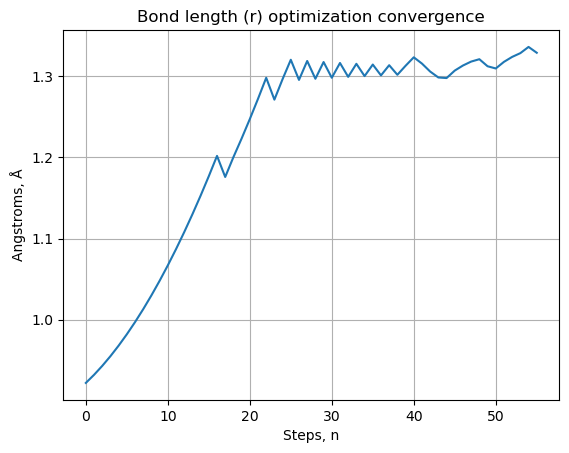

In [44]:
import matplotlib.pyplot as plt
np_bl = np.array(bond_length)
np_ba = np.array(bond_angle)
np_en = np.array(energy)
plt.plot(np_bl)
plt.xlabel("Steps, n")
plt.ylabel("Angstroms, Å")
plt.title("Bond length (r) optimization convergence")
plt.grid(True)

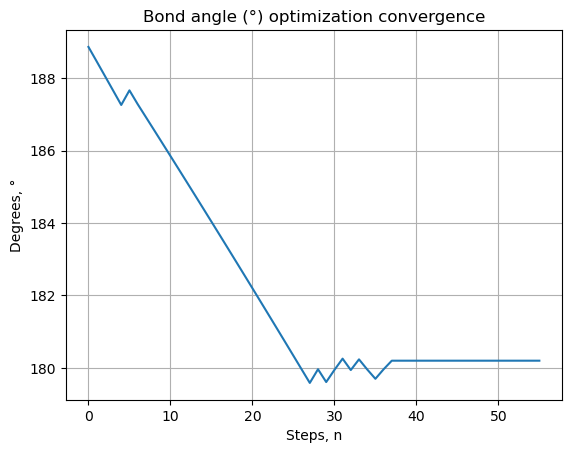

In [45]:
plt.plot(np_ba)
plt.xlabel("Steps, n")
plt.ylabel("Degrees, \u00b0")
plt.title("Bond angle (\u00b0) optimization convergence")
plt.grid(True)

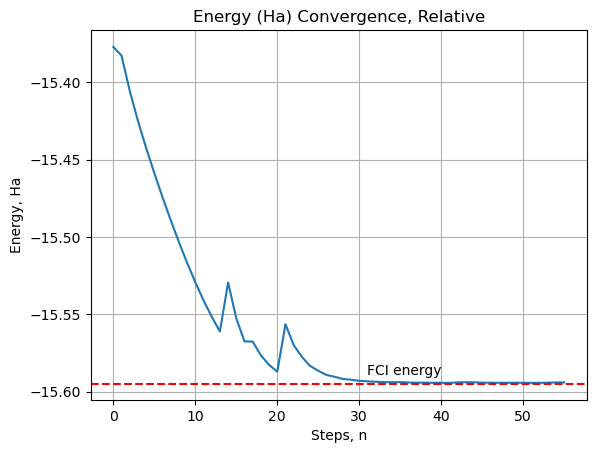

In [51]:
plt.plot(energy)
plt.xlabel("Steps, n")
plt.ylabel("Energy, Ha")
plt.title("Energy (Ha) Convergence, Relative")

plt.axhline(y=-15.59512681225857, color='r', linestyle='--')
plt.text(40, -15.589, 'FCI energy', horizontalalignment='right')

plt.grid(True)

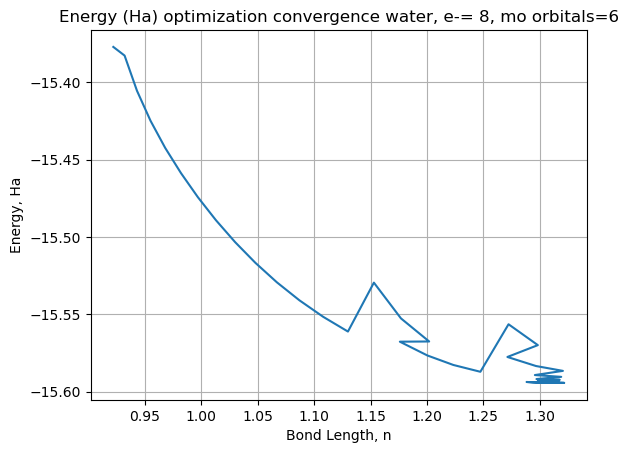

In [29]:
plt.plot(np_bl, np_en)
plt.xlabel("Bond Length, n")
plt.ylabel("Energy, Ha")
plt.title("Energy (Ha) optimization convergence water, e-= 8, mo orbitals=6")
plt.grid(True)

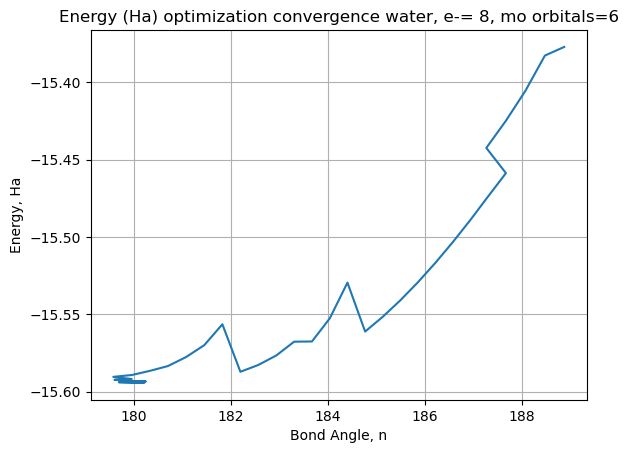

In [30]:
plt.plot(np_ba, np_en)
plt.xlabel("Bond Angle, n")
plt.ylabel("Energy, Ha")
plt.title("Energy (Ha) optimization convergence water, e-= 8, mo orbitals=6")
plt.grid(True)